# Looking to analyze ripples during cat/FR when the same category is reinstated during encoding

In [1]:
import pandas as pd; pd.set_option('display.max_columns', 30)
import numpy as np
from cmlreaders import CMLReader, get_data_index
from ptsa.data.filters import ButterworthFilter
import sys
import os
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import *
from copy import copy
from scipy import stats
import pickle
plt.rcParams['pdf.fonttype'] = 42; plt.rcParams['ps.fonttype'] = 42 # fix fonts for Illustrator
sys.path.append('/home1/john/Downloads/ptsa_plot-master/')
sys.path.append('/home1/john/johnModules')
from brain_labels import MTL_labels, LTC_labels, PFC_labels, OTHER_labels, ALL_labels # all location labels
%load_ext autoreload
%autoreload
from general import *
from SWRmodule import *
import seaborn as sb

df = get_data_index("r1") # all RAM subjects
exp = 'FR1' # 'FR1' 'catFR1'

/home1/efeghhi/.conda/envs/env1/lib/python3.7/site-packages/ptsa/data/timeseries.py:526: FutureWarning: xarray subclass TimeSeriesX should explicitly define __slots__
  class TimeSeriesX(TimeSeries):
/home1/efeghhi/.conda/envs/env1/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# sub lists I've been using to explore FR1 

subs = ['R1010J'] #'R1385E'] # ['R1065J'] #
# subs = ['R1002P','R1003P','R1006P','R1010J','R1112M','R1163T'] # initial 6 for hippocampus

# subs = subs+['R1001P','R1092J','R1151E','R1320D'] # additional subs with issues that I resolved with various RR and corr thresholds
# subs = ['R1112M','R1018P','R1020J','R1022J','R1023J','R1026D','R1027J'] # 7 with entorhinal
# subs = ['R1010J','R1112M'] # original 2 # R1108J beatiful catFR1 data; R1065J magical subject (like with FR1)
# subs = ['R1112M','R1163T'] # subjects with FR1 and catFR1. SRs of 1000 and 500 tho
# subs = ['R1151E'] # all channels X sessions get removed but 3 after 60/180 hz line removal
# these should all be worked out now. See SWR FR1 problem sessions PPT on Box for details of each
# subs = ['R1299T','R1332M','R1397D','R1349T','R1339D','R1337E','R1275D','R1151E','R1123C','R1120E','R1045E'] # final surrounding_recall problem subs after looking at huge raster!
# subs = ['R1308T','R1338T','R1358T'] # these guys had weird SRs and some loading problems when I went to whole_retrieval analysis...fixed with rounding
# subs = ['R1023J','R1101T','R1148P','R1368T','R1323T','R1334T'] # single session subs with memory allocation errors in ClusterRun
# subs = ['R1006P','R1010J','R1030J','R1032D','R1049J','R1051J','R1052E','R1054J','R1093J','R1098D','R1104D','R1108J','R1111M',
#         'R1115T','R1118N','R1124J','R1207J','R1230J','R1316T','R1329T','R1323T','R1337E','R1367D'] # subs that didn't load on 2020-07-04 encoding run
# subs = ['R1368T','R1461T','R1463E'] # subs with particularly low localization.pair matches in pairs...see Excel in loading info on Box for details
subs = ['R1433E','R1355T','R1367D','R1368T'] # subs with "ca3" or "dg"
# subs = ['R1001P'] # subject with over 8000 FR1 trials X electrodes
# bad_subs = ['R1433E','R1051J'] # no electrode cats
# subs = ['R1379E','R1385E','R1387E','R1394E','R1402E'] # partial beep subs
# subs = ['R1379E','R1402E','R1396T','R1395M','R1415T','R1389J','R1404E']  # test subs for eeg offset correction
# subs = ['R1054J','R1345D','R1048E','R1328E','R1308T', # first 2 are sr ≥ 1000. 3rd is 500 Hz.
#         'R1137E','R1136N','R1094T','R1122E','R1385E', # nice example FR1 subs used in Fig. 2
#         'R1405E','R1486J','R1501J'] # adding in 3 catFR only patients that will go into Fig. 4
# subs = ['R1120E','R1349T','R1397D','R1332M','R1299T'] # FR1 patients with electrode search ranges limited per SWR problem sessions doc on Box
# subs = ['R1269E','R1328E','R1367D','R1397D','R1405E','R1405E','R1447M','R1469D'] # catFR1 patients with electrode search changes limited
subs = ['R1461T']

sub_df = df[(df.subject.isin(subs))  & (df.experiment == exp)] # all sessions for subs
# sub_df = df[(df.subject.isin(subs))  & (df.experiment == exp) & (df.session==1)] # single session
# sub_df = df[(df.experiment == exp) & (df.session == 0)] # all FR subs 
# sub_df = sub_df[0:1]
sub_df

,Recognition,all_events,contacts,experiment,import_type,localization,math_events,montage,original_experiment,original_session,pairs,ps4_events,session,subject,subject_alias,system_version,task_events
2154,NaN,protocols/r1/subjects/R1461T/experiments/FR1/s...,protocols/r1/subjects/R1461T/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1461T/experiments/FR1/s...,0,NaN,NaN,protocols/r1/subjects/R1461T/localizations/0/m...,NaN,0,R1461T,R1461T,3.4,protocols/r1/subjects/R1461T/experiments/FR1/s...


In [4]:
# 575 FR sessions. first 18 of don't load so skip those 
exp_df = df[df.experiment==exp]
if exp == 'FR1':
    exp_df = exp_df[
                    ((df.subject!='R1015J') | (df.session!=0)) & 
                    ((df.subject!='R1063C') | (df.session!=1)) & 
                    ((df.subject!='R1093J') | (~df.session.isin([1,2]))) &
                    ((df.subject!='R1100D') | (~df.session.isin([0,1,2]))) &
                    ((df.subject!='R1120E') | (df.session!=0)) &
                    ((df.subject!='R1122E') | (df.session!=2)) &
                    ((df.subject!='R1154D') | (df.session!=0)) &
                    ((df.subject!='R1186P') | (df.session!=0)) &
                    ((df.subject!='R1201P') | (~df.session.isin([0,1]))) &
                    ((df.subject!='R1216E') | (~df.session.isin([0,1,2]))) &
                    ((df.subject!='R1277J') | (df.session!=0)) &
                    ((df.subject!='R1413D') | (df.session!=0)) & 
                    ((df.subject!='R1123C') | (df.session!=2)) & # artifacts that bleed through channels (see SWR FR1 prob sessions ppt)
                    ((df.subject!='R1151E') | (~df.session.isin([1,2]))) & # more bleed-through artifacts (see same ppt)
                    ((df.subject!='R1275D') | (df.session!=3))  # 3rd session an actual repeat of 2nd session (Paul should have removed from database by now)
    #                 (df.subject!='R1065J') # sub with 9000 trials
                   ] 
if exp == 'catFR1': 
    exp_df = exp_df[
                    ((df.subject!='R1044J') | (df.session!=0)) & # too few trials to do pg pairwise corr
                    ((df.subject!='R1491T') | (~df.session.isin([1,3,5]))) & # too few trials to do pg pairwise corr
                    ((df.subject!='R1486J') | (~df.session.isin([4,5,6,7]))) & # repeated data...will be removed at some point... @@
                    ((df.subject!='R1501J') | (~df.session.isin([0,1,2,3,4,5]))) & # these weren't catFR1 (and they don't load right anyway)
                    ((df.subject!='R1235E') | (df.session!=0)) & # split EEG filenames error...documented on Asana
                    ((df.subject!='R1310J') | (df.session!=1)) & # session 1 is just a repeat of session 0
                    ((df.subject!='R1239E') | (df.session!=0)) # some correlated noise (can see in catFR1 problem sessions ppt)
    ]
exp_df.shape
# exp_df = exp_df[257:] # for catFR1 this is R1385E-onwwards
# exp_df = exp_df[472:] # for FR1 this is R1385E-onwwards
# exp_df = exp_df[:50]
exp_df

/home1/efeghhi/.conda/envs/env1/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,Recognition,all_events,contacts,experiment,import_type,localization,math_events,montage,original_experiment,original_session,pairs,ps4_events,session,subject,subject_alias,system_version,task_events
6,NaN,protocols/r1/subjects/R1001P/experiments/FR1/s...,protocols/r1/subjects/R1001P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1001P/experiments/FR1/s...,0,NaN,0,protocols/r1/subjects/R1001P/localizations/0/m...,NaN,0,R1001P,R1001P,NaN,protocols/r1/subjects/R1001P/experiments/FR1/s...
7,NaN,protocols/r1/subjects/R1001P/experiments/FR1/s...,protocols/r1/subjects/R1001P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1001P/experiments/FR1/s...,0,NaN,1,protocols/r1/subjects/R1001P/localizations/0/m...,NaN,1,R1001P,R1001P,NaN,protocols/r1/subjects/R1001P/experiments/FR1/s...
15,NaN,protocols/r1/subjects/R1002P/experiments/FR1/s...,protocols/r1/subjects/R1002P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1002P/experiments/FR1/s...,0,NaN,0,protocols/r1/subjects/R1002P/localizations/0/m...,NaN,0,R1002P,R1002P,NaN,protocols/r1/subjects/R1002P/experiments/FR1/s...
16,NaN,protocols/r1/subjects/R1002P/experiments/FR1/s...,protocols/r1/subjects/R1002P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1002P/experiments/FR1/s...,0,NaN,1,protocols/r1/subjects/R1002P/localizations/0/m...,NaN,1,R1002P,R1002P,NaN,protocols/r1/subjects/R1002P/experiments/FR1/s...
23,NaN,protocols/r1/subjects/R1003P/experiments/FR1/s...,protocols/r1/subjects/R1003P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1003P/experiments/FR1/s...,0,NaN,NaN,protocols/r1/subjects/R1003P/localizations/0/m...,NaN,0,R1003P,R1003P,1.0,protocols/r1/subjects/R1003P/experiments/FR1/s...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2549,NaN,protocols/r1/subjects/R1565T/experiments/FR1/s...,protocols/r1/subjects/R1565T/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1565T/experiments/FR1/s...,0,NaN,NaN,protocols/r1/subjects/R1565T/localizations/0/m...,NaN,0,R1565T,R1565T,1.0,protocols/r1/subjects/R1565T/experiments/FR1/s...
2559,NaN,protocols/r1/subjects/R1569T/experiments/FR1/s...,protocols/r1/subjects/R1569T/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1569T/experiments/FR1/s...,0,NaN,NaN,protocols/r1/subjects/R1569T/localizations/0/m...,NaN,0,R1569T,R1569T,1.0,protocols/r1/subjects/R1569T/experiments/FR1/s...
2564,NaN,protocols/r1/subjects/R1571T/experiments/FR1/s...,protocols/r1/subjects/R1571T/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1571T/experiments/FR1/s...,0,NaN,NaN,protocols/r1/subjects/R1571T/localizations/0/m...,NaN,0,R1571T,R1571T,1.0,protocols/r1/subjects/R1571T/experiments/FR1/s...
2568,NaN,protocols/r1/subjects/R1572T/experiments/FR1/s...,protocols/r1/subjects/R1572T/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1572T/experiments/FR1/s...,0,NaN,NaN,protocols/r1/subjects/R1572T/localizations/0/m...,NaN,0,R1572T,R1572T,1.0,protocols/r1/subjects/R1572T/experiments/FR1/s...


# Load CLUSTER data

In [13]:
## Now to load data from cluster, have to go through and append across sessions

### params that clusterRun used (note that exp is defined in first cell so can get exp_df above)

selected_period = 'encoding'
# 'whole_encoding': aligned to 1st word of each encoding period and ends 29.7 s later (average time for 12 words to be shown)
# 'encoding': aligned to word_on

recall_type_switch = 0
loaded_files = 0
attempted_loads = 0

recall_minimum = 2000 # used if recall_type_switch = 3
region_name = 'HPC' #'ENT' #'HPC' #HPC_ENT #ENT #HPC # PHC # nonHPC_MTL # ENTPHC
remove_soz_ictal = 0 # 0 for nothing, 1 for remove SOZ, 2 for keep ONLY SOZ ###
filter_type = 'hamming' # butter/hamming/hamming125200/tried hamming140250 for math
sub_selection = 'whole' # 'second_half', 'whole' ,'first_half'
                              # analyze first 40%, remaining 60% of data, or whole? 
                              # works for FR1 and catFR1
###

# get strings for path name for save and loading cluster data
if recall_type_switch in [0,4,6,8]:
    # for these I'm using all trials, but selecting for which recall after the fact
    soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,0,selected_period,recall_minimum)
else: # these others I haven't set up indexing (see >line 100 in this cell)
    soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,recall_type_switch,selected_period,recall_minimum)
    
ripple_array = []; 
trial_nums = []; encoded_word_key_array = []
HPC_names = []; sub_sess_names = []
region_electrode_ct = []; sub_names = []
trial_by_trial_correlation = []; elec_ripple_rate_array = []
elec_by_elec_correlation = []; fr_array = []
list_num_key = []; category_array = [] # need these two to analyze categories during encoding

serialpos_array = []; list_recall_num_array = []; # ~~~
rectime_array = []; recall_before_intrusion_array = []
recall_position_array = []
semantic_clustering_key = []; temporal_clustering_key = []
session_events = pd.DataFrame()

electrode_labels = []; channel_coords = []; channel_nums = []

analysis_df = getSplitDF(exp_df,sub_selection,exp,selected_period)

for row in analysis_df.itertuples(): #analysis_df.itertuples(): #sub_df.itertuples():  #analysis_df.itertuples(): 
    attempted_loads += 1
    try:
        sub = row.subject; session = row.session; exp = row.experiment
            
        path_name = '/scratch/john/SWR_scratch/'+subfolder
#         path_name = '/scratch/john/SWR_semantic_scratch/ENCODING/2023-03-14_working_files_prior_to_adding_HFA_clustering'

        fn = os.path.join(path_name,
            'SWR_'+exp+'_'+sub+'_'+str(session)+'_'+region_name+'_'+selected_period+recall_selection_name+
                          '_'+soz_label+'_'+filter_type+'.p') #'_no_param_removal.p')   #'.p') #+'.intrusions.p') # +'.-wrong.p') (for wrong math)
        
                    
        with open(fn,'rb') as f:
            dat = pickle.load(f)
            

            ripple_array = superVstack(ripple_array,dat['ripple_array']) 
            
            region_electrode_ct.append(dat['region_electrode_ct'])
            encoded_word_key_array.extend(dat['encoded_word_key_array'])
            HPC_names.extend(dat['HPC_names'])
            sub_sess_names.extend(dat['sub_sess_names'])
            sub_names.extend(dat['sub_names'])
            trial_nums = np.append(trial_nums,dat['trial_nums'])
            trial_by_trial_correlation.extend(dat['trial_by_trial_correlation']) # one value for each electrode for this session
            elec_by_elec_correlation = np.append(elec_by_elec_correlation,dat['elec_by_elec_correlation'])
            elec_ripple_rate_array.extend(dat['elec_ripple_rate_array']) # ripple rate by electrode so append
            #,'total_recalls':total_recalls, 'kept_recalls':kept_recalls}, f)
            session_events = session_events.append(dat['session_events']) # doesn't append in place 
            
            # specific to whole_encoding
            serialpos_array.extend(dat['serialpos_array'])
            recall_position_array.extend(dat['recall_position_array']) # 1-indexed
            list_recall_num_array.extend(dat['list_recall_num_array'])
            
            electrode_labels.extend(dat['electrode_labels'])
            channel_coords.extend(dat['channel_coords'])
#             channel_nums.extend(dat['channel_nums']) # no channel_nums in Clustering code for whatever reason
            list_num_key.extend(dat['list_num_key'])
            if exp == 'catFR1':
                category_array.extend(dat['category_array'])
                semantic_clustering_key.extend(dat['semantic_clustering_key'])
            #elif exp == 'FR1':
                #temporal_clustering_key.extend(dat['temporal_clustering_key'])
                
            loaded_files += 1
            
    except Exception as e:
        LogDFExceptionLine(row, e, 'ClusterLoadSWR_log.txt')  
        
print('**Done reading data**')
        
## loading *all* the recalls with 0, but if it's 4 or 6 load just those trials

# trying new method of loading...translate these to ripple_array length dependent on recall_type_switch 
# (this way I can always load from recall_type_switch = 0)

subject_name_array,session_name_array,electrode_array,channel_coords_array = getSubSessPredictors(
        sub_names,sub_sess_names,trial_nums,electrode_labels,channel_coords)

# spread out encoded_word_key too so I know which words were correct
word_correct_array = []
for sess_elec in encoded_word_key_array:
    word_correct_array.extend(sess_elec)
word_correct_array = np.array(word_correct_array)
word_correct_array[word_correct_array>0] = 1 # 1s and 2s are corrects

# serialpos too!
sp_array = []
for sp in serialpos_array:
    sp_array.extend(sp)
serialpos_array = sp_array

print(f"Len of encoded work key {len(encoded_word_key_array)}")

# this is same as word_correct_array just 0/1/2 instead of 0/1s
temp = []
for enc in encoded_word_key_array:
    temp.extend(enc)
encoded_word_key_array = copy(temp)


print(f"Len of encoded work key {len(encoded_word_key_array)}")

print("UNIQUE SESSIONS: ", np.unique(session_name_array).shape)


# temp_recall_idxs = np.array(list_recall_num_array)>=0 # just keep them all
    
# subject_name_array = np.array(subject_name_array)[temp_recall_idxs]
# session_name_array = np.array(session_name_array)[temp_recall_idxs]
# electrode_array = np.array(electrode_array)[temp_recall_idxs]
# channel_coords_array = np.array(channel_coords_array)[temp_recall_idxs]
# channel_nums_array = np.array(channel_nums_array)[temp_recall_idxs]
# ripple_array = np.array(ripple_array)[temp_recall_idxs]
# rectime_array = np.array(rectime_array)[temp_recall_idxs]
# list_recall_num_array = np.array(list_recall_num_array)[temp_recall_idxs]
# recall_position_array = np.array(recall_position_array)[temp_recall_idxs]
    
print('**Done translating to ripple_array frame**!!')
print('...')
    
## some info on data loaded from cluster runs ##
ripple_array.shape

region_electrode_ct = np.array(region_electrode_ct)
# print('Number of electrodes in each session: '); region_electrode_ct
print('From '+str(sum(region_electrode_ct>0))+'/'+str(len(region_electrode_ct))+' sessions with >0 '+region_name+' electrodes')
print('Total trials: '+str(int(np.sum(trial_nums))))
print('Unique sessions: '+str(len(np.unique(sub_sess_names))))
print('...from '+str(len(np.unique(subject_name_array)))+' patients')

# some info about regions 
sub_elec = [subject_name_array[i]+electrode_array[i] for i in range(len(electrode_array))]
print('Number of electrodes: '+str(len(np.unique(sub_elec))))

print('Electrode regions X sessions:')
unique_names = np.unique(HPC_names)
for name in unique_names:
    num_elecs = sum(np.array([names.find(name) for names in HPC_names])>=0)
    print(str(num_elecs)+' for '+name)

FR1
2023-06-29_15-21-28: DF Exception: Sub: R1001P, Sess: 0, FileNotFoundError, [Errno 2] No such file or directory: '/scratch/john/SWR_scratch/ENCODING/SWR_FR1_R1001P_0_HPC_encoding_soz_in_hamming.p', file: <ipython-input-13-e86a1fe7172a>, line no: 60
2023-06-29_15-21-28: DF Exception: Sub: R1001P, Sess: 1, FileNotFoundError, [Errno 2] No such file or directory: '/scratch/john/SWR_scratch/ENCODING/SWR_FR1_R1001P_1_HPC_encoding_soz_in_hamming.p', file: <ipython-input-13-e86a1fe7172a>, line no: 60
2023-06-29_15-21-28: DF Exception: Sub: R1002P, Sess: 0, FileNotFoundError, [Errno 2] No such file or directory: '/scratch/john/SWR_scratch/ENCODING/SWR_FR1_R1002P_0_HPC_encoding_soz_in_hamming.p', file: <ipython-input-13-e86a1fe7172a>, line no: 60
2023-06-29_15-21-28: DF Exception: Sub: R1002P, Sess: 1, FileNotFoundError, [Errno 2] No such file or directory: '/scratch/john/SWR_scratch/ENCODING/SWR_FR1_R1002P_1_HPC_encoding_soz_in_hamming.p', file: <ipython-input-13-e86a1fe7172a>, line no: 60


# Get start_array and select subfield if HPC for free recalls

In [7]:
## DO YOU WANT TO SELECT A SUBFIELD or OUTPUT POSITION?? ##  

select_subfield = True   # note: if you already ran this once, have to load again from data
                          # also this is only for HPC. So set to False for ENT and PHC
    
# select for subfield if HPC
if select_subfield == True:
    location_selected = 'ca1' #['ca1','dg'] #'dg' # 'ca3' # 'dg' 'ca1' # sub # ['ca1','dg']
        # left # right # left hippocampus # right hippocampus # hippocampus
        # to see number of each: sum(np.array([names.find('sub') for names in HPC_names])>=0)
else:
    location_selected = ''
    
### Use a task condition to select recalls?? ###
### ...will select first one that's not 0    ###
select_ordinal_position = 0              # select only recalls at given output position. 0 means it's off ##DEPRECATED
select_less_than_rectime = 0             # select only recalls < this number % 5000
select_greater_than_rectime = 0          # select only recalls ≥ this number % 5000
select_lists_with_recalls = 0 # list(np.arange(3,13)) # [1] so this would select ≥4 recalls. Must be list hence the list(arange...)
                                         # select only recalls that come from lists with number in this list
select_intrusions_next = 0               # select recalls that lead to intrusions
    
if filter_type.find('hamming') != -1:
    desired_sample_rate = 500.
else:
    desired_sample_rate = 1000.
sr = desired_sample_rate # fixed at this value since this is the minimum across data and can always downsample
sr_factor = 1000/desired_sample_rate

print('Total electrodes loaded: '+str(len(trial_nums)))
print('from '+str(len(np.unique(sub_sess_names)))+' sessions from '+str(len(np.unique(sub_names)))+' subjects with trial nums:')
print(trial_nums[0:20])
print('Trial sum = '+str(np.sum(trial_nums)))
# print(HPC_names[0:20])
print('Number of sub_sess names: '+str(len(sub_sess_names)))


start_array,end_array = getStartEndArrays(ripple_array); print('Got encoding start_array!')
 
# if selected an output position
if select_ordinal_position > 0:
    if np.min(ordinal_position_array) == 0: # only update this once (so don't have to reload data from files)
        ordinal_position_array = np.array(ordinal_position_array)+1 # now 1-indexed
    selected_recalls = ordinal_position_array==select_ordinal_position
elif select_intrusions_next == 1:
    selected_recalls = np.array(recall_before_intrusion_array)==True
elif select_less_than_rectime > 0:
    selected_recalls = np.array(rectime_array)<select_less_than_rectime
elif select_greater_than_rectime > 0:
    selected_recalls = np.array(rectime_array)>=select_greater_than_rectime
elif ( (type(select_lists_with_recalls) == list) | (isinstance(select_lists_with_recalls, np.ndarray)) ):    
    selected_recalls = [recall in select_lists_with_recalls for recall in list_recall_num_array]
else:
    selected_recalls = np.ones(len(start_array),dtype=bool)
    
# get locations if selected

if select_subfield == True:
    # create the full vector of location name predictors
    location_names = []
    for s in range(len(HPC_names)):
        new_trials = int(trial_nums[s])
        location_names.extend(np.tile(HPC_names[s],new_trials))  
        
    # now can get mask of trials in this location
    
    #first, if there are two locations to combine, sort that out (DG and CA1 in particular)
    location_mask = np.zeros(len(location_names))
    for s in range(len(location_names)):
        if type(location_selected)==list:
            if location_names[s].find(location_selected[0])>=0 or location_names[s].find(location_selected[1])>=0:
                location_mask[s] = True
        elif type(location_selected)==str:
            if location_names[s].find(location_selected)>=0:
                location_mask[s] = True
else:
    location_mask = np.ones(len(start_array))

# DON'T USE temp_recall_idxs FOR ENCODING
# # gotta translate this to new frame as well from idxs in load step if selected subfield
# if select_subfield == True: 
#     location_mask = location_mask[temp_recall_idxs] 

# combine location and sorted recalls to get new ripple array:
updated_recalls = (location_mask+selected_recalls)==2

# these lists did not have 12 word presentations, so remove them
#if exp == 'catFR1':
#    updated_recalls[(np.array(session_name_array)=='R1180C-2') & (np.array(list_num_key)==24)] = 0
#    updated_recalls[(np.array(session_name_array)=='R1278E-10') & (np.array(list_num_key)==25)] = 0
    
    
# translate these predictors to vector and select recalls
start_array = start_array[updated_recalls]
end_array = end_array[updated_recalls] # used for duration calculations
subject_name_array = np.array(subject_name_array)[updated_recalls]
session_name_array = np.array(session_name_array)[updated_recalls]
electrode_array = np.array(electrode_array)[updated_recalls]
channel_coords_array = np.array(channel_coords_array)[updated_recalls]
# channel_nums_array = np.array(channel_nums_array)[updated_recalls]

# if selected_period in ['surrounding_recall','math','math_retrieval']:
#     list_recall_num_array = list_recall_num_array[updated_recalls] # for subject-level analysis
# rectime_array = np.array(rectime_array)[updated_recalls]
# recall_position_array = np.array(recall_position_array)[updated_recalls]

# specific to encoding
# serialpos_array = np.array(serialpos_array)[updated_recalls] # FIX THIS ONCE RUN AGAIN 2021-09-16
# specific to whole_encoding
# list_recall_num_array = np.array(list_recall_num_array)[updated_recalls]

encoded_word_key_array = np.array(encoded_word_key_array)[updated_recalls]
serialpos_array = np.array(serialpos_array)[updated_recalls]
list_num_key = np.array(list_num_key)[updated_recalls]
word_correct_array = word_correct_array[updated_recalls]
recall_position_array = np.array(recall_position_array)[updated_recalls]
session_events = session_events[updated_recalls]

if exp == 'catFR1':   
    category_array = np.array(category_array)[updated_recalls]
    semantic_clustering_key = np.array(semantic_clustering_key)[updated_recalls]
elif exp == 'FR1':
    temporal_clustering_key = np.array(temporal_clustering_key)[updated_recalls]
    
print('Got start_array with '+str(start_array.shape[0])+' trials!')

sub_elec = [subject_name_array[i]+electrode_array[i] for i in range(len(electrode_array))]
print('Number of electrodes: '+str(len(np.unique(sub_elec))))
print('...from '+str(len(np.unique(subject_name_array)))+' patients')
        
# # plot whole retrieval period with FR events superimposed on SWRs
# if selected_period == 'whole_bretrieval':
#     start_array2 = start_array # for whole retrieval period
#     print('Base SWRs/30 s retrieval: '+str(sum(start_array2)/start_array2.shape[0]/(30000/1000)))
#     ## can go straight to "SWRs by time in retrieval period" from here
# else:
#     print('SWRs rate in 4 s around FR: '+str(sum(start_array)/start_array.shape[0]/(4000/1000)))

# # subplots(1,1,figsize=(6,9))
# # plot([0,0],[0,fr_array.shape[0]],linewidth=1,linestyle='-',color=(0,0,0))
# # plot(np.ones(2)*(retrieval_whole_time),[0,fr_array.shape[0]],linewidth=1,linestyle='-',color=(0,0,0))
# # scatter(np.where(start_array2)[1]*sr_factor+psth_start,np.where(start_array2)[0],s=0.5)
# # scatter(np.where(fr_array)[1],np.where(fr_array)[0],s=0.5,color=[1,0,0]); 
# # plt.xlabel('Retrieval period time (ms)')
# # plt.ylabel('Retrieval period')
# # if save_plot == 1:
# #     plt.savefig('../plots/'+'SWR_FR_'+region_name+'-'+str(session_ct)+'_sessions_in-'+str(sub_num)+'subjects_'+filter_type+'.pdf',transparent=True)
# # plt.show();    

print('# of trials: '+str(np.shape(start_array)[0]))
print('Total # of ripples: '+str(sum(start_array)))
print('Overall ripple rate: '+str(np.round( (1000/sr_factor)*sum(start_array)/np.shape(start_array)[0]/np.shape(start_array)[1],3 ))+' Hz')

Total electrodes loaded: 1291
from 243 sessions from 122 subjects with trial nums:
[120. 120. 120. 120. 120. 120. 120. 300. 300. 156. 156. 156. 156. 156.
 156. 156. 156. 216. 216. 216.]
Trial sum = 241894.0
Number of sub_sess names: 1291
Got encoding start_array!
Got start_array with 97885 trials!
Number of electrodes: 227
...from 86 patients
# of trials: 97885
Total # of ripples: 95176
Overall ripple rate: 0.324 Hz


In [8]:
start_array.shape

(97885, 1500)

In [14]:
len(ripple_array)
len(electrode_array)
len(list_num_key)
len(word_correct_array)
len(recall_position_array)
len(serialpos_array)
len(encoded_word_key_array)
len(semantic_clustering_key)
len(category_array)
len(temporal_clustering_key)
len(session_name_array)

10572

# SCE (Subsequent Clustering Effect?)

## semantic clustering for catFR

In [6]:
# select which serialpositions you're looking at (since curious if 1-6 show all the SCE)
serialpos_select = np.arange(1,13) #np.arange(1,7) # np.arange(1:13)

remove_chaining = 0 # 2022-07-19 trying a control to see if SCE still exists after removing recalls that begin with SP 1+2 in a row

# these values are all for subject-level SCE v. avg_recalls analysis
if sub_selection == 'whole':
    min_SCE_trials = 20 # minimum SCE trials in session to include in SCE v. avg_recalls plot
else:
    min_SCE_trials = 10

encoding_time = 2300 # actual preentation is 1.6 s + 0.75-1.0 s so keep +700 ms so can plot +500 ms
pre_encoding_time = -700
ripple_bin_start_end = [100,1700] # range I'm going to look for ripples for regression of serialpos and category predictors
psth_start = -700
sr_factor = 2 # downsampled ripples to 500 Hz.
stats_bin = ripple_bin_start_end[1]-ripple_bin_start_end[0] # only using 1 bin for encoding 

adj_semantic_encoding_array = []
rem_semantic_encoding_array = []
rem_unclustered_encoding_array = []
last_recall_encoding_array = [] # the last word remembered on each list (no transitions)...but make sure it's not an intrusion or repeat too!
forgot_encoding_array = []
sub_name_array0 = []; sess_name_array0 = []; elec_name_array0 = []
sub_name_array1 = []; sess_name_array1 = []; elec_name_array1 = []
sub_name_array2 = []; sess_name_array2 = []; elec_name_array2 = []
sub_name_array3 = []; sess_name_array3 = []; elec_name_array3 = []
sess_name_array4 = [] # forgot why I keep the others but leaving them 2022-06-10
sub_name_array5 = []; sess_name_array5 = []; elec_name_array5 = []

# for clsutered v. unclustered subject-level analysis (need to record at session-level though for mixed model)

sess_sessions = []
sess_delta = []
sess_subjects = []
sess_recall_num = []
sess_clust_num = []
sess_prop_semantic = []

session_names = np.unique(session_name_array)

num_sessions = 0 

for sess in session_names:
    
    sess_list_nums = np.unique(list_num_key[session_name_array==sess]) 
    
    num_sessions += 1
    
    # for each session will get a clustered and unclustered start array to get the delta SCE
    start_arrayC = []; start_arrayU = []
    # and also the proportion of semantically clustered recalls
    temp_corr = []; temp_sem_key = []
    
    for ln in sess_list_nums:
        list_elec_array = np.unique(electrode_array[(session_name_array==sess) & (list_num_key==ln)])
        
        for elec in list_elec_array:
        
            list_ch_idxs = (session_name_array==sess) & (list_num_key==ln) & (electrode_array==elec)
            
            list_ch_encoding_array = start_array[list_ch_idxs]
            list_ch_cats = category_array[list_ch_idxs]
            list_ch_corr = word_correct_array[list_ch_idxs]
            list_ch_semantic_key = semantic_clustering_key[list_ch_idxs]
            list_ch_recall_positions = recall_position_array[list_ch_idxs]
            
            # remove ones starting with serialpos 1->2 as a control (or just 1 if it's len 1)
            if remove_chaining == 1:
                if len(list_ch_recall_positions[0])==1:
                    if list_ch_recall_positions[0][0]==1: # if 1st serialpos
                        continue # get out of this loop if only one recall and it's serialpos 1
                elif len(list_ch_recall_positions[0])>0:
                    if ((list_ch_recall_positions[0][0]==1)&(list_ch_recall_positions[0][1]==2)):     
                        continue # get out of loop if recalls are serialpos 1->2 (no matter what)            

            for i_recall_type,recall_type in enumerate(list_ch_semantic_key[0]): # all 12 words have same values so just take 1st one
                recall_position = list_ch_recall_positions[0][i_recall_type] # ditto re: taking 1st
                
                if recall_position in serialpos_select: # so can select by serialpos (e.g. 1:6 or 7:12)
                    if recall_type == 'A': # adjacent semantic
#                     if recall_type in ['A','C']: # adjacent AND remote semantic
                        # note the -1 since recall positions are on scale of 1-12
                        adj_semantic_encoding_array = superVstack(adj_semantic_encoding_array,list_ch_encoding_array[recall_position-1])
                        sub_name_array0.append(sess[0:6])
                        sess_name_array0.append(sess)
                        elec_name_array0.append(elec)
                    elif recall_type == 'C': # remote semantic
                        rem_semantic_encoding_array = superVstack(rem_semantic_encoding_array,list_ch_encoding_array[recall_position-1])
                        sub_name_array1.append(sess[0:6])
                        sess_name_array1.append(sess)
                        elec_name_array1.append(elec)
                    elif ( (recall_type == 'D') ): # & (recall_position>0) ): # remote unclustered
                        rem_unclustered_encoding_array = superVstack(rem_unclustered_encoding_array,list_ch_encoding_array[recall_position-1])
                        sub_name_array2.append(sess[0:6])
                        sess_name_array2.append(sess)  
                        elec_name_array2.append(elec)
                    elif ( (recall_type == 'Z') ): #& (recall_position>0) ): # last word of list & was actually a recalled word
                        last_recall_encoding_array = superVstack(last_recall_encoding_array,list_ch_encoding_array[recall_position-1])
                        sub_name_array3.append(sess[0:6])
                        sess_name_array3.append(sess)
                        elec_name_array3.append(elec)
                    else:
                        sess_name_array4.append(sess[0:6])
                        
                # I also want to do an SCE v. avg_recall_num by subject analysis
                # to do this will combine A/C as SCE group and combine D/Z as control  
                
                if recall_position in serialpos_select: # so can select by serialpos (e.g. 1:6 or 7:12)

                    if recall_type in ['A','C']: # adjacent semantic or remote semantic
                        # note the -1 since recall positions are on scale of 1-12
                        start_arrayC = superVstack(start_arrayC,list_ch_encoding_array[recall_position-1])
                    elif ( (recall_type in ['D','Z']) & (recall_position>0) ): # remote unclustered or dead end (>0 means recalled word)
                        start_arrayU = superVstack(start_arrayU,list_ch_encoding_array[recall_position-1])
                        
                        
            # unpack semantic clustering key to trial level (only need to do once for one electrode)

            if elec == list_elec_array[0]:

                for word in range(sum(list_ch_idxs)): 

                    if (word+1) in list_ch_recall_positions[0]: # serial positions are 1-indexed so add 1 to check in list_ch_recall_positions
                        temp_corr.append(1)
                        # use index from serialpos to get clustering classification
                        if ((sess== 'R1108J-2')&(ln==25)): # single mistake shwos up
                            if word == 8:
                                temp_sem_key.append('A')
                            elif word == 9:
                                temp_sem_key.append('Z')
                        else: 
                            temp_sem_key.append(list_ch_semantic_key[0][list_ch_recall_positions[0].index(word+1)])
                    else:
                        temp_corr.append(0)
                        temp_sem_key.append('')                

    
            # make forgotten array to plot along with SCE too which is easy enough 
            forgotten_words = 1-np.array(list_ch_corr)
            if sum(forgotten_words)>0: # R1065 a whiz
                forgot_encoding_array = superVstack(forgot_encoding_array,np.array(list_ch_encoding_array)[findInd(forgotten_words),:])
                sub_name_array5.extend(np.tile(sess[0:6],int(sum(forgotten_words))))
                sess_name_array5.extend(np.tile(sess,int(sum(forgotten_words))))
                elec_name_array5.extend(np.tile(elec,int(sum(forgotten_words))))

    if ( (len(start_arrayC)>min_SCE_trials) & (len(start_arrayU)>min_SCE_trials) & (len(start_arrayC)!=1500) ): # last one in there for a len(1) start_arrayC

        # back at session-level record the delta, sub, sess, and avg_recall_num for *all* trials
        sess_sessions.append(sess)
        sess_subjects.append(sess[0:6])   

        # can just use list_elec_array to select only one electrode we know exists for this session (altho should be irrelevant when we average anyyway)
        sess_word_correct_array = word_correct_array[((electrode_array==list_elec_array[0]) & (session_name_array==sess))]
        sess_recall_num.append(12*sum(sess_word_correct_array)/len(sess_word_correct_array)) # *12 to convert to recall_num/list
        
        # while temp_sem_key is NOT in the same order as sess_word_correct_array, can use it anyway to get proportion of clustered recalls
#         if sum(temp_corr) == sum(sess_word_correct_array):
        sess_prop_semantic.append(sum([trial in ['A','C'] for trial in temp_sem_key])/sum(temp_corr))
#         else:
#             print('temp_sem_key must be messed up for '+sess+'!!')
#             print(sum(temp_corr))
#             print(sum(sess_word_correct_array))

        # calculate single delta ripples value for clust v. not clust for this session
        binned_stats_arrayC = start_arrayC[:,int((ripple_bin_start_end[0]-psth_start)/sr_factor):
                                               int((ripple_bin_start_end[1]-psth_start)/sr_factor)]
        binned_stats_arrayC = binBinaryArray(binned_stats_arrayC,stats_bin,sr_factor)
        binned_stats_arrayU = start_arrayU[:,int((ripple_bin_start_end[0]-psth_start)/sr_factor):
                                               int((ripple_bin_start_end[1]-psth_start)/sr_factor)]
        binned_stats_arrayU = binBinaryArray(binned_stats_arrayU,stats_bin,sr_factor)
        print(f"Sess {sess},  delta {np.mean(binned_stats_arrayC)-np.mean(binned_stats_arrayU)}")
        sess_delta.append(np.mean(binned_stats_arrayC)-np.mean(binned_stats_arrayU))
        
trial_nums = [len(sub_name_array0),len(sub_name_array1),len(sub_name_array2),len(sub_name_array3),len(sess_name_array4)]
                
a=1;

Sess R1221P-0,  delta 0.08458646616541354
Sess R1221P-1,  delta -0.020933014354067025
Sess R1221P-2,  delta 0.2195083014048531
Sess R1239E-1,  delta -0.05848930481283421
Sess R1269E-0,  delta 0.012019230769230782
Sess R1269E-2,  delta -0.034252095422308226
Sess R1278E-0,  delta 0.008116883116883133
Sess R1278E-10,  delta 0.0
Sess R1332M-0,  delta -0.02964975845410628
Sess R1332M-1,  delta 0.029825249243866897
Sess R1361C-2,  delta 0.027901785714285712
Sess R1426N-0,  delta 0.022624434389140274
Sess R1448T-0,  delta -0.1807598039215686
Sess R1456D-3,  delta 0.09375000000000001
Sess R1465D-2,  delta -0.09344362745098042
Sess R1477J-3,  delta 0.0069444444444444475
Sess R1482J-0,  delta 0.2152777777777778
Sess R1482J-1,  delta -0.055921052631578955
Sess R1482J-2,  delta -0.07539682539682535
Sess R1501J-6,  delta 0.06358225108225113
Sess R1501J-8,  delta 0.3153409090909091


In [7]:
sess_delta

[0.08458646616541354,
 -0.020933014354067025,
 0.2195083014048531,
 -0.05848930481283421,
 0.012019230769230782,
 -0.034252095422308226,
 0.008116883116883133,
 0.0,
 -0.02964975845410628,
 0.029825249243866897,
 0.027901785714285712,
 0.022624434389140274,
 -0.1807598039215686,
 0.09375000000000001,
 -0.09344362745098042,
 0.0069444444444444475,
 0.2152777777777778,
 -0.055921052631578955,
 -0.07539682539682535,
 0.06358225108225113,
 0.3153409090909091]

In [36]:
num_sessions

30

### SCE v. avg_recall_num (before we get to semantic clustering PVTHs)

Mixed model of ripple_rate ~ avg_recall_num at session-level


/home1/efeghhi/.conda/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/efeghhi/.conda/envs/env1/lib/python3.7/site-packages/statsmodels/base/model.py:1286: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))


                 Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   delta_ripple_rate
No. Observations:     24        Method:               REML             
No. Groups:           14        Scale:                0.0020           
Min. group size:      1         Likelihood:           12.8827          
Max. group size:      3         Converged:            Yes              
Mean group size:      1.7                                              
-----------------------------------------------------------------------
                             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------
Intercept                     0.041    0.089  0.456 0.648 -0.133  0.215
avg_recall_num               -0.005    0.020 -0.272 0.786 -0.044  0.033
subject Var                   0.000                                    
subject x avg_recall_num Cov -0.000                                    
avg_recal

/home1/efeghhi/.conda/envs/env1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home1/efeghhi/.conda/envs/env1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home1/efeghhi/.conda/envs/env1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


FileNotFoundError: [Errno 2] No such file or directory: '/home1/efegghi/SWR/figures/subject-level_plots/SCE_v_recall_catFR1_AMY__hamming_first_half.pdf'

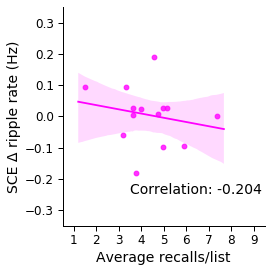

In [20]:
import seaborn as sb
import statsmodels.formula.api as smf

save_plot = 1
save_data_df = 1

sess_df = pd.DataFrame({'delta_ripple_rate':sess_delta,'avg_recall_num':sess_recall_num,
                        'session':sess_sessions,'subject':sess_subjects,'prop_semantic':sess_prop_semantic})
print('Mixed model of ripple_rate ~ avg_recall_num at session-level')        
vc = {'session':'0+session'}
sig_bin_model = smf.mixedlm("delta_ripple_rate ~ avg_recall_num", sess_df, groups="subject", vc_formula=vc,re_formula="avg_recall_num")
bin_model1 = sig_bin_model.fit(reml=True, method='nm',maxiter=2000) 
print(bin_model1.summary())
print(bin_model1.pvalues)
print(bin_model1.params)
print(bin_model1.bse_fe)

# want to plot at subject-level even though DF above is at subject_level
    
def defaultPlotting(): 
    sb.set(rc={'figure.figsize':(11.7,8.27),"font.size":20,"axes.titlesize":20,"axes.labelsize":20},style="white")

if location_selected == 'dg':
    min_rate = 0.1
    plot_color = [(0.8,0,0)]
    lmplot_color = (0.8,0,0,0)
    errorbar_color = (1,0.5,0.5)
    line_color = 'darkred'
elif location_selected == 'ca1':
    min_rate = 0.1 # for CA1 and DG I require a FR minimum for the two bins being compared since I do further stats on them
    plot_color = [(0,0,0.8)]
    lmplot_color = (0,0,0.8,0)
    errorbar_color = (0.5,0.5,1)
    line_color = 'darkblue'
else:
    lmplot_color = (1,0,1)
    line_color = (1,0,1)    

# convert session-level df to subject-level for plot
sub_delta = []
sub_recall_num = []
sub_prop_semantic = []
for sub in np.unique(sess_subjects):
    sub_delta.append(np.mean(np.array(sess_delta)[np.array(sess_subjects) == sub]))
    sub_recall_num.append(np.mean(np.array(sess_recall_num)[np.array(sess_subjects) == sub]))
    sub_prop_semantic.append(np.mean(np.array(sess_prop_semantic)[np.array(sess_subjects) == sub]))

set_pubfig()
deltaRR_df = pd.DataFrame({'avg_recall_num':sub_recall_num,'ripple_rates':sub_delta,'prop_semantic':sub_prop_semantic})
fig, ax = subplots(figsize=(4,4))
sb.regplot(ax=ax,x='avg_recall_num',y='ripple_rates',data=deltaRR_df,
         scatter_kws = {'color': lmplot_color},line_kws = {'color': line_color})

if exp == 'FR1':
    gca().set(ylim=(-0.31,0.31),xlim=(0.5,7.5))
    xticks(np.arange(1,7.5+0.01,1))
elif exp == 'catFR1':
    gca().set(ylim=(-0.35,0.35),xlim=(0.5,9.5))
    xticks(np.arange(1,9.5+0.01,1))
gca().tick_params(labelsize=12)

plot_corr = stats.pearsonr(sub_recall_num,sub_delta)

annotate('Correlation: '+str(np.round(plot_corr[0],3)),(3.5,-0.25)) 
# annotate('p-values: '+str(np.round(plot_corr[1],3)),(3.5,-0.29)) # use mixed model p-value instead:
# annotate('$\it{P}$-value: '+str(np.round(bin_model1.pvalues[1],3)),(3.5,-0.29))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)   
tight_layout()

ylabel(u'SCE Δ ripple rate (Hz)')
xlabel('Average recalls/list')
if type(location_selected)==list:
    location_selected = location_selected[0]+location_selected[1]
    
if save_plot == 1:
    if type(location_selected)==list:
        location_selected = 'ca1dg'
    fname = '/home1/efegghi/SWR/figures/subject-level_plots/SCE_v_recall_'+exp+'_'+region_name+'_'+\
        location_selected+'_'+filter_type+'_'+sub_selection+'.pdf'
    savefig(fname,format='pdf',transparent=True)
if save_data_df == 1:
    if type(location_selected)==list:
        location_selected = 'ca1dg'
    fname = '/home1/efegghi/SWR/figures/subject-level_plots/SCE_v_recall_'+exp+'_'+region_name+'_'+\
        location_selected+'_'+filter_type+'_'+sub_selection+'.p'
    with open(fname,'wb') as f:
        pickle.dump({'sess_df':sess_df}, f)
    
a=1;


### proportion of semantic recalls vs. SCE (make sure you run cell before first)

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/base/model.py:1286: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


                Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   delta_ripple_rate
No. Observations:    73        Method:               REML             
No. Groups:          42        Scale:                0.0014           
Min. group size:     1         Likelihood:           71.0336          
Max. group size:     4         Converged:            Yes              
Mean group size:     1.7                                              
----------------------------------------------------------------------
                            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                    0.027    0.034  0.800 0.423 -0.039  0.093
prop_semantic               -0.070    0.073 -0.956 0.339 -0.213  0.073
subject Var                  0.000                                    
subject x prop_semantic Cov -0.000                                    
prop_semantic Var      

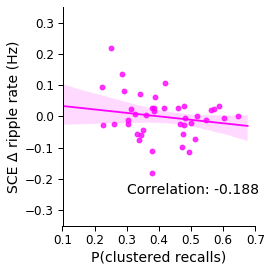

In [249]:
import seaborn as sb
import statsmodels.formula.api as smf

save_plot = 1

sig_bin_model2 = smf.mixedlm("delta_ripple_rate ~ prop_semantic", sess_df, groups="subject", vc_formula=vc,re_formula="prop_semantic")
bin_model2 = sig_bin_model2.fit(reml=True, method='nm',maxiter=2000) 
print(bin_model2.summary())
print(bin_model2.pvalues)
print(bin_model2.params)
print(bin_model2.bse_fe)

# want to plot at subject-level even though DF above is at subject_level
    
def defaultPlotting(): 
    sb.set(rc={'figure.figsize':(11.7,8.27),"font.size":20,"axes.titlesize":20,"axes.labelsize":20},style="white")

set_pubfig()
fig, ax = subplots(figsize=(4,4))
sb.regplot(ax=ax,x='prop_semantic',y='ripple_rates',data=deltaRR_df,
         scatter_kws = {'color': lmplot_color},line_kws = {'color': line_color})

xticks(np.arange(0,0.701,0.1))
if exp == 'FR1':
    gca().set(ylim=(-0.31,0.31),xlim=(0.5,7.5))
elif exp == 'catFR1':
    gca().set(ylim=(-0.35,0.35),xlim=(0.1,0.7))
gca().tick_params(labelsize=12)

plot_corr = stats.pearsonr(sub_prop_semantic,sub_delta)

if location_selected == 'ca1':
    annotate('Correlation: '+str(np.round(plot_corr[0],3)),(0.3,-0.33)) 
elif location_selected == 'dg':
    annotate('Correlation: '+str(np.round(plot_corr[0],3)),(0.3,-0.25))
else:
    annotate('Correlation: '+str(np.round(plot_corr[0],3)),(0.3,-0.25)) 
# annotate('p-values: '+str(np.round(plot_corr[1],3)),(3.5,-0.29)) # use mixed model p-value instead:
# annotate('$\it{P}$-value: '+str(np.round(bin_model1.pvalues[1],3)),(3.5,-0.29))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)   
tight_layout()

ylabel(u'SCE Δ ripple rate (Hz)')
xlabel('P(clustered recalls)')
if type(location_selected)==list:
    location_selected = location_selected[0]+location_selected[1]
    
if save_plot == 1:
    if type(location_selected)==list:
        location_selected = 'ca1dg'
    fname = '/home1/efegghi/SWR/figures/subject-level_plots/SCE_v_clustered_recalls_'+exp+'_'+region_name+'_'+\
        location_selected+'_'+filter_type+'_'+sub_selection+'.pdf'
    savefig(fname,format='pdf',transparent=True)
    
a=1;


## plot three (or two) on same

done making binned start_array with shape:
(7148, 30)
done making binned start_array with shape:
(1448, 30)
done making binned start_array with shape:
(1526, 30)


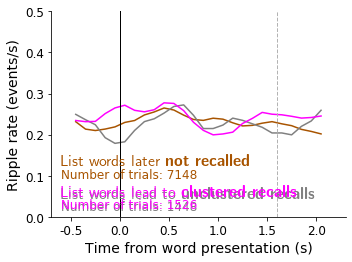

In [17]:
# (make sure you run semantic clustering for catFR cell first)

save_fig = 0
plot_SE = 0 # if you only want to do stats making this 0 will be much quicker since it doesn't do the ME model at each bin
            # this must be 1 if plot_ME_mean is 1
plot_ME_mean = 0 # 0 for typical PSTH; 1 for ME mean; 2 for average across sub averages

# get PSTH for two of the types
plot_three = [5,4,6] ## for clust v. unclust model: [5,4,6] # SCE contrast: [4,6]; SME contrast: # [5,4]
# 0 is adjacent_semantic, 1 is remote_semantic, 
# 2 is remote unclustered, 3 is dead end, 
# 4 is combined remote unclustered & dead end
# 5 is not recalled
# 6 is combined clustering (adjacent semantic and remote semantic)

bin_size = 100 # in ms
smoothing_triangle = 5 # triangular smoothing window width
pad = int(np.floor(smoothing_triangle/2)) # factor is how many points from middle does triangle go?
text_height = 0.21

ripple_bin_start_end = [100,1700]
encoding_range = range(int((-pre_encoding_time+ripple_bin_start_end[0])/sr_factor),int((-pre_encoding_time+ripple_bin_start_end[1])/sr_factor)) 
# comes to 400:1200 for 100 to 1700 of 1500 len timeseries

ME_start_array = []
ME_sub_name_array = []
ME_session_name_array = []
ME_indicator = [] # keeps track of trial type in comparison defined above (e.g. clustered v. not)

# for recalled and then forgotten words
for i_array,array_num in enumerate(plot_three):
    if array_num == 0:
        temp_start_array = adj_semantic_encoding_array
#         label = 'List words lead to \\textbf{semantic transition}'        
        label = 'List words lead to \\textbf{adjacent semantic}'
        plot_color = (1,0.33,0)
    elif array_num == 1:
        temp_start_array = rem_semantic_encoding_array
        label = 'List words lead to \\textbf{remote semantic}'
        plot_color = (0,0.66,1)
    elif array_num == 2:
        temp_start_array = rem_unclustered_encoding_array
        label = 'List words lead to \\textbf{remote unclustered}'
        plot_color = (0,0.3,0)
    elif array_num == 3:
        temp_start_array = last_recall_encoding_array
        label = 'List words lead to \\textbf{dead end}'
        plot_color = (0,0,0.3)
    elif array_num == 5:
        temp_start_array = forgot_encoding_array
        label = 'List words later \\textbf{not recalled}'
        plot_color = (.66,0.33,0)
        if location_selected == '':
            text_height = 0.125        
    elif array_num == 4:
        temp_start_array = superVstack(rem_unclustered_encoding_array,last_recall_encoding_array)
        label = 'List words lead to \\textbf{unclustered recalls}'
        plot_color = (0.5,0.5,0.5)
        sub_name_array4 = sub_name_array2+sub_name_array3
        sess_name_array4 = sess_name_array2+sess_name_array3
        elec_name_array4 = elec_name_array2+elec_name_array3
        if location_selected == '':
            text_height = 0.125
    elif array_num == 6:
        temp_start_array = superVstack(adj_semantic_encoding_array,rem_semantic_encoding_array)
        label = 'List words lead to \\textbf{clustered recalls}'
        if location_selected == 'ca1':
            plot_color = (0,0.66,1)
            text_height = 0.21
        elif location_selected == 'dg':
            plot_color = (1,0.33,0.66)
            text_height = 0.21
        else:
            plot_color = (1,0,1)
            text_height = 0.125
        sub_name_array6 = sub_name_array0+sub_name_array1
        sess_name_array6 = sess_name_array0+sess_name_array1
        elec_name_array6 = elec_name_array0+elec_name_array1        
    else:
        print('not using this array_num, pick another my guy')
        break
        
    sub_name_array = eval('sub_name_array'+str(array_num))
    sess_name_array = eval('sess_name_array'+str(array_num))
    elec_name_array = eval('elec_name_array'+str(array_num))
    
    # update accumulating totals for ME model
    ME_start_array = superVstack(ME_start_array,temp_start_array)
    ME_sub_name_array = np.concatenate((ME_sub_name_array,sub_name_array))
    ME_session_name_array = np.concatenate((ME_session_name_array,sess_name_array))
    ME_indicator.extend(np.repeat(i_array,len(temp_start_array)))

    if array_num == plot_three[0]:
        # for plot
        subplots(1,1,figsize=(5,3.75))
        text(-600,text_height,label,usetex=True,size=16,color=plot_color) 
        text(-600,text_height-0.03,'Number of trials: '+str(temp_start_array.shape[0]),color=plot_color,size=12)
    elif array_num == plot_three[1]:
        text(-600,text_height-0.08,label,usetex=True,size=16,color=plot_color) 
        text(-600,text_height-0.11,'Number of trials: '+str(temp_start_array.shape[0]),color=plot_color,size=12)
    else:
        text(-600,0.05,label,usetex=True,size=16,color=plot_color) 
        text(-600,0.02,'Number of trials: '+str(temp_start_array.shape[0]),color=plot_color,size=12)        
        
    # make a PSTH based on start times of SWRs

    PSTH,bin_centers = fullPSTH(temp_start_array,bin_size,smoothing_triangle,sr,pre_encoding_time)

    # get binned start array (trials X bins)
    binned_start_array = binBinaryArray(temp_start_array,bin_size,sr_factor)

    print('done making binned start_array with shape:')
    print(binned_start_array.shape)

    # note that output is the net ± distance from mean
    if plot_SE == True:
        mean_plot,SE_plot = getMixedEffectMeanSEs(binned_start_array,sub_name_array,sess_name_array) #,elec_name_array)
        print('SEs created!')
        
    if plot_ME_mean == 1:
        PSTH = triangleSmooth(mean_plot,smoothing_triangle) # replace PSTH with means from ME model (after smoothing as usual)
    elif plot_ME_mean == 2: # average across subs first
        temp_means = []
        for sub in np.unique(sub_name_array):
            temp_means = superVstack(temp_means,np.mean(binned_start_array[np.array(sub_name_array)==sub],0))
        PSTH = triangleSmooth(np.mean(temp_means,0),smoothing_triangle)
        SE_sub_level = np.std(temp_means,0)/np.sqrt(len(temp_means))
    # plot
    xr = bin_centers #np.arange(psth_start,psth_end,binsize)
    xr = xr[pad:-pad]
    if pad > 0:
        binned_start_array = binned_start_array[:,pad:-pad] # remove edge bins
        PSTH = PSTH[pad:-pad] 
        if plot_SE == True:
            SE_plot = SE_plot[:,pad:-pad]
    
    plot(xr,PSTH,color=plot_color)
    if plot_SE == True:
        fill_between(xr, PSTH-SE_plot[0,:], PSTH+SE_plot[0,:], alpha = 0.3, facecolor=plot_color)
        
xticks(np.arange(pre_encoding_time+pad*100,encoding_time-pad*100+1,500),
       np.arange((pre_encoding_time+pad*100)/1000,(encoding_time-pad*100)/1000+1,500/1000))
xlabel('Time from word presentation (s)',fontsize=14)
ylabel('Ripple rate (events/s)',fontsize=14)
ax = plt.gca()
ylim = 0.5
ax.set_ylim(0,ylim)
ax.set_xlim(pre_encoding_time,encoding_time)
plot([0,0],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=1,linestyle='-',color=(0,0,0))
plot([1600,1600],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=1,linestyle='--',color=(0.7,0.7,0.7))
xticks(fontsize=12)
yticks(fontsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)   
tight_layout()

# cell below uses comp_str so grab it regardless
if type(location_selected)==list:
    location_selected = 'ca1dg'
    
if len(plot_three)==3:
    comp_str = str(plot_three[0])+'-'+str(plot_three[1])+'-'+str(plot_three[2])
elif len(plot_three)==2:
    comp_str = str(plot_three[0])+'-'+str(plot_three[1])
        
if save_fig == 1:
    # get strings for path name for save and loading cluster data

    path_name = '/home1/efegghi/SWR/figures/ENCODING/'
    fn = os.path.join(path_name,
        'semantic_clustering_'+exp+'_'+region_name+'_'+\
        location_selected+'_'+filter_type+'_'+sub_selection+comp_str+'_'+str(plot_ME_mean)+'.pdf')
    plt.savefig(fn,transparent=True)  

a=1;

In [282]:
# SCE model

save_data = 0 # saving the data lets you do the SCE * brain_region interaction below

import statsmodels.api as sm
import statsmodels.formula.api as smf
## for the stats for each of these I'm comparing the first two to the 3rd one
# i.e. [0,1,4] is adjacent and remote semantic each vs. combined SME
# and [2,3,5] is remote unclustered and dead end each vs. not recalled
ME_ripple_rate = np.sum(ME_start_array[:,encoding_range],1)/((ripple_bin_start_end[1]-ripple_bin_start_end[0])/1000)
clust_df = pd.DataFrame({'ripple_rate':ME_ripple_rate,'indicator':ME_indicator,
                        'session':ME_sub_name_array,'subject':ME_session_name_array})
vc = {'session':'0+session'}
clust_model = smf.mixedlm("ripple_rate ~ C(indicator)", clust_df, groups="subject", vc_formula=vc,re_formula="C(indicator)")
clust_results = clust_model.fit(reml=True, method='nm',maxiter=2000) 
print(clust_results.summary())
print('**p-values**:'); print(clust_results.pvalues)
print('**coefs**:'); print(clust_results.params)
print('**SEs**:'); print(clust_results.bse_fe)

# if want to save data to compare across regions

if save_data == 1:

    path_name = '/home1/efegghi/SWR/compiled/ENCODING/'
    fn = os.path.join(path_name,
        'semantic_clustering_'+exp+'_'+region_name+'_'+\
        location_selected+'_'+filter_type+'_'+sub_selection+comp_str+'.p')           
    with open(fn,'wb') as f:
        pickle.dump({'clust_df':clust_df,'comp_str':comp_str}, f)
        
# R1 asked for ANOVA as well (do this after saving clust_df or can't save full df for indicator*region test below)
key = ['subject','indicator']
clust_df = clust_df.groupby(key).mean().reset_index() # averages ripple rates for correct and incorrect within each patient
OLS_model = smf.ols("ripple_rate ~ indicator", clust_df).fit()
print('Simple ANOVA:')
print(OLS_model.summary())        



/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                       Mixed Linear Model Regression Results
Model:                     MixedLM          Dependent Variable:          ripple_rate
No. Observations:          60972            Method:                      REML       
No. Groups:                125              Scale:                       0.2138     
Min. group size:           82               Likelihood:                  -39679.2182
Max. group size:           2079             Converged:                   Yes        
Mean group size:           487.8                                                    
------------------------------------------------------------------------------------
                                          Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------
Intercept                                  0.218    0.009 24.890 0.000  0.201  0.235
C(indicator)[T.1]                         -0.013    0.006 -2.187 0.029 -0.025 -0.001
C(in

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/base/model.py:1286: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


### Comparing clustered and unclustered directly

In [251]:
import statsmodels.formula.api as smf

# Need to run [5,4,6] to get the correct df, since need the not recalled (5), recalled but not clustered (4), and clustered (6)

ME_ripple_rate = np.sum(ME_start_array[:,encoding_range],1)/((ripple_bin_start_end[1]-ripple_bin_start_end[0])/1000)
clust_df = pd.DataFrame({'ripple_rate':ME_ripple_rate,'indicator':ME_indicator,
                        'session':ME_sub_name_array,'subject':ME_session_name_array})

# now alter this df to make a recalled column and a clustered column
clust_df['clustered'] = clust_df.indicator==2
clust_df['recalled'] = clust_df.indicator!=0

vc = {'session':'0+session'}
clust_model = smf.mixedlm("ripple_rate ~ recalled+clustered", clust_df, groups="subject", vc_formula=vc,
                          re_formula="recalled+clustered")
clust_results = clust_model.fit(reml=True, method='nm',maxiter=2000) 
print(clust_results.summary())
print('**p-values**:'); print(clust_results.pvalues)
print('**coefs**:'); print(clust_results.params)
print('**SEs**:'); print(clust_results.bse_fe)

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                       Mixed Linear Model Regression Results
Model:                     MixedLM          Dependent Variable:          ripple_rate
No. Observations:          40032            Method:                      REML       
No. Groups:                104              Scale:                       0.1734     
Min. group size:           66               Likelihood:                  -21915.9428
Max. group size:           1631             Converged:                   Yes        
Mean group size:           384.9                                                    
------------------------------------------------------------------------------------
                                         Coef.   Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------
Intercept                                 0.197     0.010 20.769 0.000  0.179  0.216
recalled[T.True]                          0.005     0.008  0.668 0.504 -0.010  0.020
clus

### Comparison across regions (using data saved from last cell)

In [256]:
import statsmodels.formula.api as smf

regions_to_compare = ['AMY','HPC'] # put one you want as 0 first
locations_for_regions = ['','ca1'] # THIS NEEDS TO MATCH WITH PREVIOUS LINE
comps = [4,6] # I saved the dataframes as clustered and unclustered comparisons so unpack from this

path_name = '/home1/john/SWR/compiled/ENCODING/'

for reg in range(len(regions_to_compare)):
    region_name = regions_to_compare[reg]
    location_selected = locations_for_regions[reg]
    comp_str = str(comps[0])+'-'+str(comps[1])
    fn = os.path.join(path_name,
        'semantic_clustering_'+exp+'_'+region_name+'_'+\
        location_selected+'_'+filter_type+'_'+sub_selection+comp_str+'.p') 

    with open(fn,'rb') as f:
        dat = pickle.load(f)
        print(len(dat['clust_df']))
    if reg == 0:
        comb_df = dat['clust_df']
        comb_df['region'] = np.zeros(len(comb_df))
    elif reg == 1:
        temp_df = dat['clust_df']
        temp_df['region'] = np.ones(len(temp_df))
        comb_df = pd.concat([comb_df,temp_df],ignore_index=True)
        
vc = {'session':'0+session'}
# comb_df.indicator = 1-comb_df.indicator # so clustered is now 1
reg_model = smf.mixedlm("ripple_rate ~ indicator*region", comb_df, groups="subject", vc_formula=vc,
                        re_formula='indicator*region')
reg_results = reg_model.fit(reml=True, method='nm',maxiter=2000) 
print(reg_results.summary())
print('**p-values**:'); print(reg_results.pvalues)
coefs = reg_results.params
print('**coefs**:'); print(coefs)
print('**SEs**:'); print(reg_results.bse_fe)
a=1;

11815
32095


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                   Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       ripple_rate
No. Observations:       43910         Method:                   REML       
No. Groups:             212           Scale:                    0.2626     
Min. group size:        7             Likelihood:               -33230.0247
Max. group size:        1935          Converged:                Yes        
Mean group size:        207.1                                              
---------------------------------------------------------------------------
                                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------
Intercept                         0.201    0.011 18.645 0.000  0.180  0.222
indicator                         0.003    0.011  0.255 0.799 -0.018  0.023
region                            0.110    0.015  7.403 0.000  0.081  0.139
indicator:region               

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/base/model.py:1286: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


## same idea but comparing SCE v. recall and p(clustering) plots between regions

In [186]:
import statsmodels.formula.api as smf

regions_to_compare = ['nonHPC_MTL','HPC'] # put one you want as 0 first
locations_for_regions = ['','ca1'] # THIS NEEDS TO MATCH LOGIC OF PREVIOUS LINE
sub_selection = 'whole' # 'second_half' # don't need to load anything previous as long as saved data using "save_data_df" previously

path_name = '/home1/john/SWR/compiled/ENCODING/'

for reg in range(len(regions_to_compare)):
    region_name = regions_to_compare[reg]
    location_selected = locations_for_regions[reg]
    fn = '/home1/john/SWR/figures/subject-level_plots/SCE_v_recall_'+exp+'_'+region_name+'_'+\
        location_selected+'_'+filter_type+'_'+sub_selection+'.p'

    with open(fn,'rb') as f:
        dat = pickle.load(f)
        print(len(dat['sess_df']))
    if reg == 0:
        comb_df = dat['sess_df']
        comb_df['region'] = np.zeros(len(comb_df))
    elif reg == 1:
        temp_df = dat['sess_df']
        temp_df['region'] = np.ones(len(temp_df))
        comb_df = pd.concat([comb_df,temp_df],ignore_index=True)
        
vc = {'session':'0+session'}
reg_model = smf.mixedlm("delta_ripple_rate ~ avg_recall_num*region", comb_df, groups="subject", vc_formula=vc, re_formula='avg_recall_num*region')
reg_results = reg_model.fit(reml=True, method='nm',maxiter=2000) 
print('****Avg_recall_num X region model:****')
print(reg_results.summary())
print('**p-values**:'); print(reg_results.pvalues)
coefs = reg_results.params
print('**coefs**:'); print(coefs)
print('**SEs**:'); print(reg_results.bse_fe)


reg_model = smf.mixedlm("delta_ripple_rate ~ prop_semantic*region", comb_df, groups="subject", vc_formula=vc, re_formula='prop_semantic*region')
reg_results = reg_model.fit(reml=True, method='nm',maxiter=2000) 
print('****Prop_semantic X region model****:')
print(reg_results.summary())
print('**p-values**:'); print(reg_results.pvalues)
coefs = reg_results.params
print('**coefs**:'); print(coefs)
print('**SEs**:'); print(reg_results.bse_fe)
a=1;

sess_df = pd.DataFrame({'delta_ripple_rate':sess_delta,'avg_recall_num':sess_recall_num,
                        'session':sess_sessions,'subject':sess_subjects,'prop_semantic':sess_prop_semantic})

88
122


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2115: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2566: RuntimeWarning: invalid value encountered in sqrt
  sdf[0:self.k_fe, 1] = np.sqrt(np.diag(self.cov_params()[0:self.k_fe]))
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: Runt

****Avg_recall_num X region model:****
                     Mixed Linear Model Regression Results
Model:                   MixedLM      Dependent Variable:      delta_ripple_rate
No. Observations:        210          Method:                  REML             
No. Groups:              85           Scale:                   0.0061           
Min. group size:         1            Likelihood:              187.3822         
Max. group size:         8            Converged:               Yes              
Mean group size:         2.5                                                    
--------------------------------------------------------------------------------
                                           Coef.  Std.Err. z P>|z| [0.025 0.975]
--------------------------------------------------------------------------------
Intercept                                   0.046                               
avg_recall_num                             -0.005                               
region     

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


****Prop_semantic X region model****:
                       Mixed Linear Model Regression Results
Model:                    MixedLM       Dependent Variable:       delta_ripple_rate
No. Observations:         210           Method:                   REML             
No. Groups:               85            Scale:                    0.0060           
Min. group size:          1             Likelihood:               193.3357         
Max. group size:          8             Converged:                Yes              
Mean group size:          2.5                                                      
-----------------------------------------------------------------------------------
                                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------
Intercept                                 0.054    0.048  1.130 0.258 -0.040  0.149
prop_semantic                            -0.069    0.107 -0.6

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2115: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/base/model.py:1286: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
